# Imports

In [1]:
import numpy as np
import nd2
import matplotlib.pyplot as plt
from scipy import ndimage
from tqdm import tqdm
from matplotlib.patches import Rectangle
from scipy.ndimage import gaussian_filter
import os
import h5py


In [3]:
os.getcwd()

'/nfs/home2/kirjner/whole-worm-imaging'

# Setup

In [2]:
path = './data/nd2/worm_1_010.nd2'
with nd2.ND2File(path) as f:
    print(f.sizes)
    print(f.metadata)
worm_array = nd2.imread(path)

#To make life easier for testing
TEST_SIZE=500
uncropped_test_array = worm_array[:TEST_SIZE, np.newaxis, :, :]

{'T': 1577, 'Y': 1024, 'X': 1024}
Metadata(contents=Contents(channelCount=1, frameCount=1577), channels=[Channel(channel=ChannelMeta(name='EM525/50', index=0, color=Color(r=127, g=255, b=0, a=1.0), emissionLambdaNm=547.5, excitationLambdaNm=None), loops=LoopIndices(NETimeLoop=None, TimeLoop=0, XYPosLoop=None, ZStackLoop=None), microscope=Microscope(objectiveMagnification=40.0, objectiveName='Apo LWD 40x WI λS DIC N2', objectiveNumericalAperture=1.15, zoomMagnification=1.0, immersionRefractiveIndex=1.333, projectiveMagnification=1.0, pinholeDiameterUm=50.0, modalityFlags=['fluorescence', 'spinningDiskConfocal']), volume=Volume(axesCalibrated=(True, True, False), axesCalibration=(0.325, 0.325, 1.0), axesInterpretation=('distance', 'distance', 'distance'), bitsPerComponentInMemory=16, bitsPerComponentSignificant=12, cameraTransformationMatrix=(1.0, 0.0, 0.0, 1.0), componentCount=1, componentDataType='unsigned', voxelCount=(1024, 1024, 1), componentMaxima=[0.0], componentMinima=[0.0], pixe

# Cropping

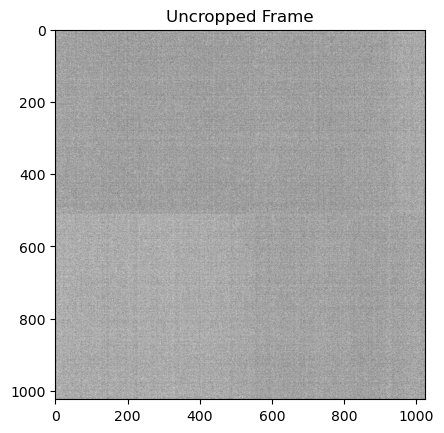

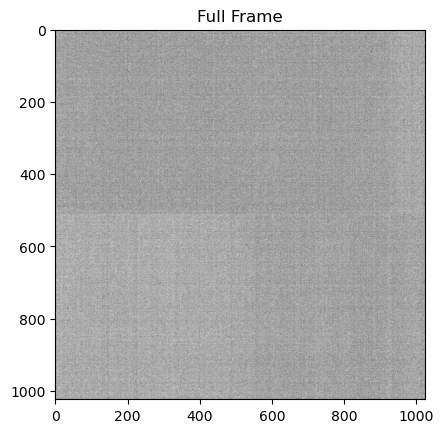

In [8]:
# Currently, we do the cropping visually. 
# Note we only have T x Y x X, no C for this array
# Display frame 1 of the uncropped test array in grayscale
# Note: uncropped_test_array has shape (time, height, width)
plt.imshow(uncropped_test_array[20], cmap='Greys')
plt.title("Uncropped Frame")
plt.show()
# Let's look at the full frame first without cropping
plt.imshow(uncropped_test_array[20], cmap='Greys')
plt.title("Full Frame")
plt.show()

'''
by (my) inspection, y_min ~= 200, y_max ~= 750, x_min ~=300, x_max ~= 850
#someone else might inspect differently. If so, change the constants. It's good
#to crop first if possible to not waste time processing parts of the array that don't
matter
'''



test_array = uncropped_test_array[:1000]


# Aligning

## Visualizing shift and period

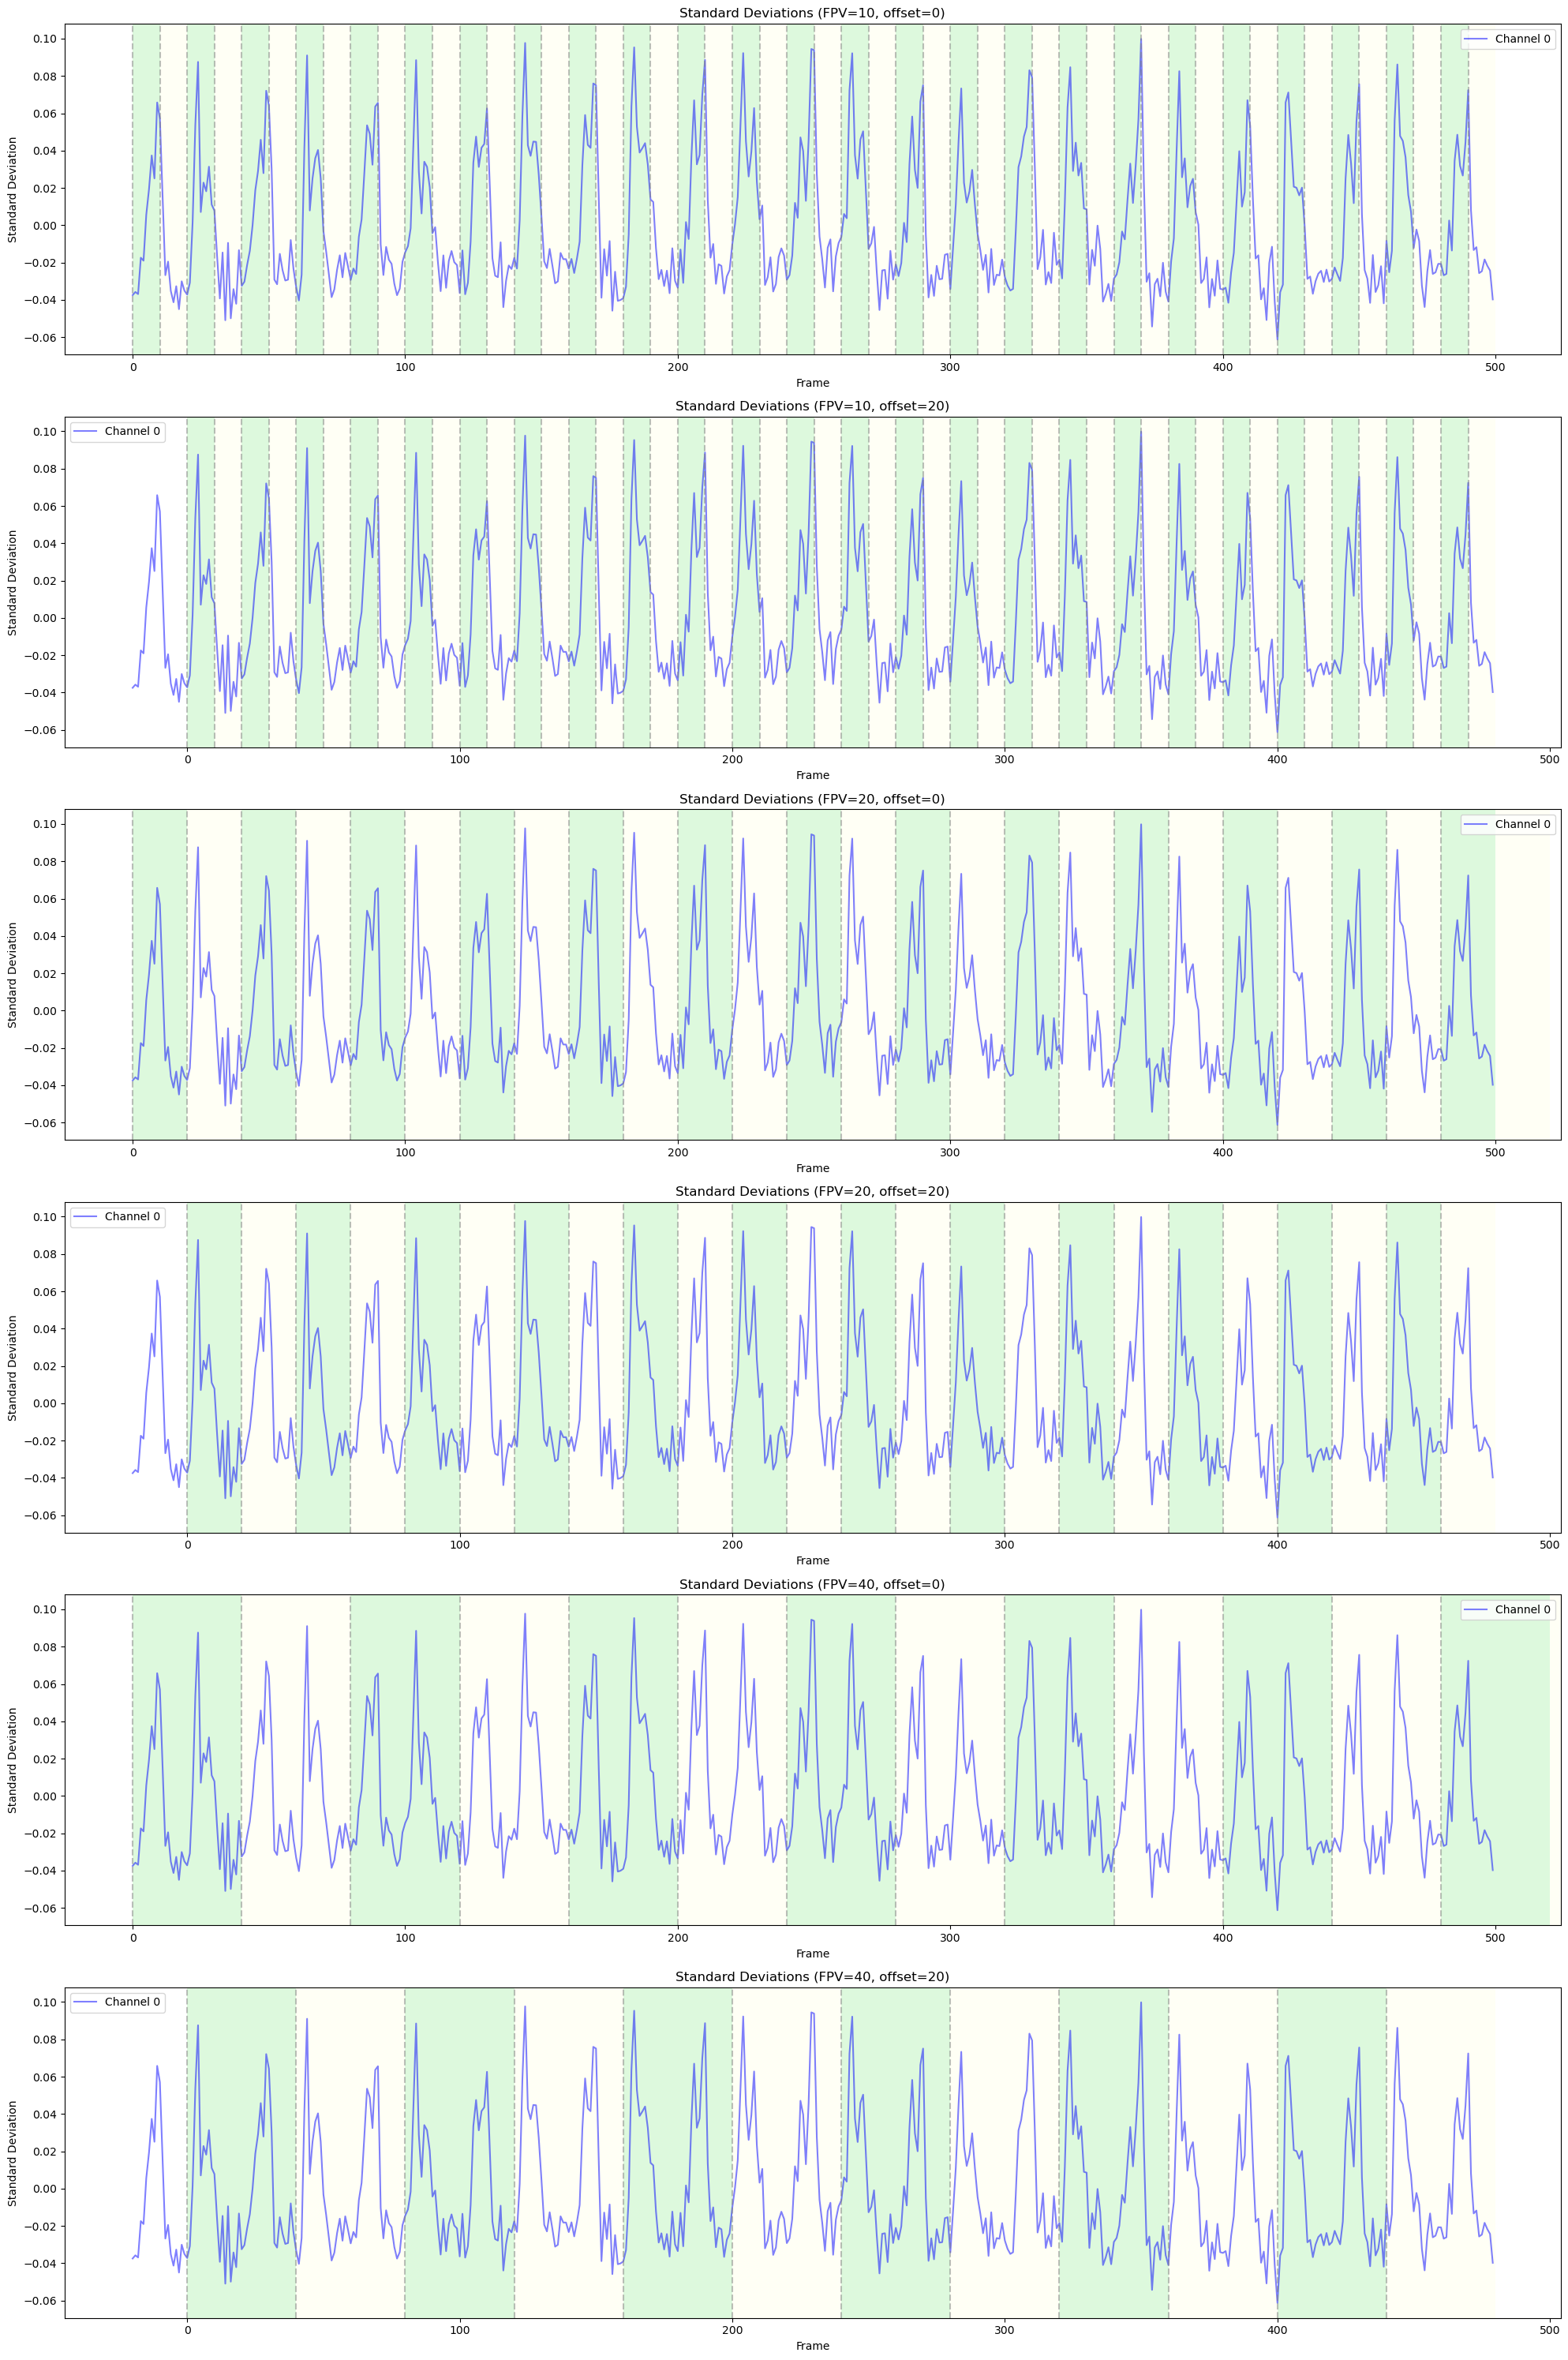

In [34]:
def plot_intensity_vs_frame(arr, start_idx=17, frames_per_volume=20, title = None):
    """
    Plot mean intensities and standard deviations of a 3D or 4D array.
    
    Parameters:
    arr (np.array): 3D array of shape (time, height, width) or 
                    4D array of shape (time, channel, height, width)
    start_idx (int): Starting index of the first volume
    frames_per_volume (int): Number of frames per volume
    """
    # Handle both 3D and 4D arrays
    if arr.ndim == 3:
        # For 3D array, add channel dimension
        arr = arr[:, np.newaxis, :, :]
        
    mean_intensities = np.mean(arr, axis=(2,3))
    std_intensities = np.std(arr, axis=(2,3))

    fig = plt.figure(figsize=(20, 30))
    gs = plt.GridSpec(6, 1, figure=fig)
    
    fpv_list = [10, 20, 40]
    offset_list = [0, 20]
    
    for i, fpv in enumerate(fpv_list):
        for j, offset in enumerate(offset_list):
            # Create subplot for standard deviations
            ax = fig.add_subplot(gs[i*2 + j])
            ax.set_title(f'Standard Deviations (FPV={fpv}, offset={offset})')
            ax.set_xlabel('Frame')
            ax.set_ylabel('Standard Deviation')
            
            xx = np.arange(-offset, arr.shape[0] - offset)

            # Plot each channel
            for c in range(arr.shape[1]):
                ax.plot(xx, std_intensities[:,c] - np.mean(std_intensities[:,c]), 
                        label=f'Channel {c}', 
                        color='blue' if c==0 else 'red', 
                        alpha=0.5)
            ax.legend()

            # Add colored rectangles to show alternating periods
            colors = ['lightgreen', 'lightyellow']
            ymin, ymax = ax.get_ylim()
            height = ymax - ymin
            
            for k in range(0, arr.shape[0]-offset, fpv*2):
                # First period
                rect = Rectangle((k, ymin), fpv, height, facecolor=colors[0], alpha=0.3)
                ax.add_patch(rect)
                # Second period
                rect = Rectangle((k+fpv, ymin), fpv, height, facecolor=colors[1], alpha=0.3)
                ax.add_patch(rect)

            # Add vertical lines for volume boundaries
            for k in range(0, arr.shape[0]-offset, fpv):
                ax.axvline(x=k, color='gray', linestyle='--', alpha=0.5)

    if title:
        fig.suptitle(title, fontsize=28)
    plt.tight_layout()
    plt.show()


# Usage example:
# test_array can be either:
# - 3D numpy array of shape (time, height, width)
# - 4D numpy array of shape (time, channel, height, width)
plot_intensity_vs_frame(test_array)


In [61]:
import numpy as np
from scipy.ndimage import gaussian_filter, median_filter, uniform_filter
from skimage import morphology
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import HTML
from multiprocessing import Pool, cpu_count
from functools import partial
from time import time
from tqdm import tqdm

def process_frame(frame, kernel_sizes=[3, 5], sigma1=1.5, sigma2=6.0):
    """
    Apply hierarchical median filtering followed by DoG to a single frame
    
    Parameters:
    -----------
    frame : numpy.ndarray
        3D array representing single frame (C, H, W)
    kernel_sizes : list
        List of kernel sizes for hierarchical filtering
    sigma1, sigma2 : float
        DoG filter parameters (smaller and larger Gaussian sigmas)
        
    Returns:
    --------
    filtered : numpy.ndarray
        Filtered frame with same shape as input, preserving positive values for thresholding
    """
    # Remove channel dimension
    frame = frame[0]
    
    # 1. Apply median filters in sequence
    filtered = frame.copy()
    for kernel_size in kernel_sizes:
        filtered = median_filter(filtered, size=kernel_size)
    
    # 2. Apply DoG filter
    smooth1 = gaussian_filter(filtered, sigma=sigma1)
    smooth2 = gaussian_filter(filtered, sigma=sigma2)
    dog_result = smooth1 - smooth2
    
    # 3. Normalize to preserve positive values for thresholding
    dog_result = dog_result - np.min(dog_result)  # Make all values positive
    dog_result = dog_result / np.max(dog_result)  # Normalize to [0,1] range
    
    # Add back channel dimension
    return dog_result[np.newaxis, ...]

def enhanced_calcium_filter(data, kernel_sizes=[3, 5], n_jobs=-1, threshold_percentile=85, 
                          sigma1=1.5, sigma2=6.0):
    """
    Apply hierarchical median filtering to calcium imaging data
    + thresholding
    
    Parameters:
    -----------
    data : numpy.ndarray
        Input array of shape (T, C, H, W)
    kernel_sizes : list
        List of kernel sizes for hierarchical filtering
    n_jobs : int
        Number of parallel processes (-1 for all cores)
    threshold_percentile : float
        Percentile for global thresholding
    sigma1, sigma2 : float
        DoG filter parameters
    """
    if n_jobs == -1:
        n_jobs = cpu_count()
    start_time = time()
    print(f"Starting hierarchical median filtering using {n_jobs} processes...")
    
    # Convert to float32
    data = np.array(data, dtype=np.float32)
    
    # Process frames in parallel
    process_frame_partial = partial(process_frame, 
                                  kernel_sizes=kernel_sizes,
                                  sigma1=sigma1,
                                  sigma2=sigma2)
    frames_to_process = [data[i] for i in range(len(data))]
    
    with Pool(n_jobs) as pool:
        result = list(tqdm(
            pool.imap(process_frame_partial, frames_to_process),
            total=len(frames_to_process),
            desc="Processing frames"
        ))
    
    result = np.array(result)
    
    # Calculate threshold after all processing
    threshold = np.percentile(result, threshold_percentile)
    
    # Apply thresholding
    result[result < threshold] = 0
    
    total_time = time() - start_time
    print(f"\nFiltering complete! Total time: {total_time:.2f} seconds")
    
    return result

def create_hot_orange():
    """
    Creates a custom 'hot orange' colormap optimized for calcium imaging.
    """
    colors = ['black', '#3C1518', '#69140E', '#A44200', '#D58936', '#FFB627']
    return LinearSegmentedColormap.from_list('hot_orange', colors)

def create_fire():
    """
    Creates a custom 'fire' colormap.
    """
    colors = ['black', '#240046', '#3C096C', '#5A189A', '#7B2CBF', 
              '#9D4EDD', '#C77DFF', '#FF7900', '#FF9E00', '#FFC300']
    return LinearSegmentedColormap.from_list('fire', colors)

def create_filtered_animation(array, interval=50, cmap='hot_orange', percentile=(1, 99),
                            figsize=(8, 8), title_prefix="", dpi=150,
                            kernel_sizes=[3], threshold_percentile=85):
    """
    Create an enhanced animation with filtered frames and separate scaling
    
    Parameters:
    -----------
    array : numpy.ndarray
        Array to animate with shape (T, C, H, W)
    interval : int
        Animation interval in milliseconds
    cmap : str
        Colormap choice ('hot_orange', 'fire', 'inferno', 'magma', 'plasma')
    percentile : tuple
        Lower and upper percentiles for contrast stretching
    figsize : tuple
        Figure size in inches
    title_prefix : str
        Optional prefix for frame titles
    dpi : int
        DPI for the output video
    kernel_sizes : list
        List of kernel sizes for hierarchical filtering
    threshold_percentile : float
        Percentile for global thresholding
    """
    # Filter the data
    filtered_array = enhanced_calcium_filter(array, 
                                          kernel_sizes=kernel_sizes, 
                                          threshold_percentile=threshold_percentile)
    
    # Select colormap
    if cmap == 'hot_orange':
        cmap = create_hot_orange()
    elif cmap == 'fire':
        cmap = create_fire()
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(figsize[0]*2, figsize[1]), dpi=dpi)
    
    # Calculate separate value limits for original and filtered data
    vmin_orig, vmax_orig = np.percentile(array, percentile)
    vmin_filt, vmax_filt = np.percentile(filtered_array[filtered_array > 0], percentile)  # Only non-zero values
    
    # Initialize with first frame (removing channel dimension for display)
    im1 = ax1.imshow(array[0, 0], cmap=cmap, vmin=vmin_orig, vmax=vmax_orig)
    im2 = ax2.imshow(filtered_array[0, 0], cmap=cmap, vmin=vmin_filt, vmax=vmax_filt)
    
    ax1.axis('off')
    ax2.axis('off')
    ax1.set_title('Original')
    ax2.set_title(f'Filtered (threshold: {threshold_percentile}th percentile)')
    
    # Add colorbars with appropriate scaling
    plt.colorbar(im1, ax=ax1, label='Original Intensity')
    plt.colorbar(im2, ax=ax2, label='Filtered Intensity')
    
    # Main title
    suptitle = fig.suptitle(f'{title_prefix}Frame 0/{len(array)-1}')
    
    def update(frame):
        im1.set_array(array[frame, 0])
        im2.set_array(filtered_array[frame, 0])
        suptitle.set_text(f'{title_prefix}Frame {frame}/{len(array)-1}')
        return [im1, im2, suptitle]
    
    print("Creating animation...")
    anim = FuncAnimation(fig, update, frames=len(array), 
                        interval=interval, blit=True)
    
    plt.close()
    
    return HTML(anim.to_html5_video(embed_limit=50000))

# Example usage:
# filtered_video = create_filtered_animation(your_array,  # Shape: (T, C, H, W)
#                                          interval=50,
#                                          cmap='hot_orange',
#                                          sigma=2,
#                                          threshold_multiplier=3,
#                                          min_size=20)
# display(filtered_video)

In [6]:
# based on the full animation, we see that the bottom 10% and the top 25% are fixed, so we define 
# cropped_test_array
height = uncropped_test_array.shape[2]
y_min = int(height * 0.25)  # Skip top 25%
y_max = int(height * 0.9)   # Skip bottom 10%
cropped_test_array = uncropped_test_array[:, :, y_min:y_max, :]



In [33]:
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import HTML
from multiprocessing import Pool, cpu_count
from functools import partial
from time import time
from tqdm import tqdm

def dog_filter_2d(im, sigma1=0.5, sigma2=4):
    """Apply a difference of Gaussians filter"""
    im1 = gaussian_filter(im.astype(np.float32), sigma1)
    im2 = gaussian_filter(im.astype(np.float32), sigma2)
    return im1 - im2

def process_frame(frame):
    """Process a single frame with DoG filter"""
    frame = frame[0]  # Remove channel dimension
    filtered = dog_filter_2d(frame, sigma1=0.5, sigma2=8)
    return filtered[np.newaxis, ...]  # Add back channel dimension

def enhanced_calcium_filter(data, n_jobs=-1, threshold_percentile=85):
    """Apply DoG filtering to calcium imaging data"""
    if n_jobs == -1:
        n_jobs = cpu_count()
    start_time = time()
    print(f"Starting DoG filtering using {n_jobs} processes...")
    
    data = np.array(data, dtype=np.float32)
    frames_to_process = [data[i] for i in range(len(data))]
    
    with Pool(n_jobs) as pool:
        result = list(tqdm(
            pool.imap(process_frame, frames_to_process),
            total=len(frames_to_process),
            desc="Processing frames"
        ))
    
    result = np.array(result)
    threshold = np.percentile(result, threshold_percentile)
    result[result < threshold] = 0
    
    total_time = time() - start_time
    print(f"\nFiltering complete! Total time: {total_time:.2f} seconds")
    return result

def create_hot_orange():
    """Creates a custom 'hot orange' colormap"""
    colors = ['#1a1a1a', '#3C1518', '#69140E', '#A44200', '#D58936', '#FFB627']
    return LinearSegmentedColormap.from_list('hot_orange', colors)

def create_fire():
    """Creates a custom 'fire' colormap"""
    colors = ['#1a1a1a', '#240046', '#3C096C', '#5A189A', '#7B2CBF', 
              '#9D4EDD', '#C77DFF', '#FF7900', '#FF9E00', '#FFC300']
    return LinearSegmentedColormap.from_list('fire', colors)

def create_animation(array, data_type="Original", interval=50, cmap='hot_orange', 
                    percentile=(1, 99.9), figsize=(12, 12), dpi=150, fpv=20):  # Added fpv parameter
    """Create a single animation"""
    if cmap == 'hot_orange':
        cmap = create_hot_orange()
    elif cmap == 'fire':
        cmap = create_fire()
    
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = plt.gca()
    
    if np.any(array > 0):
        vmin, vmax = np.percentile(array[array > 0], percentile)
    else:
        vmin, vmax = np.percentile(array, percentile)
    
    im = ax.imshow(array[0, 0], cmap=cmap, vmin=vmin, vmax=vmax)
    ax.axis('off')
    
    def volume_frame_info(frame_idx, fpv):
        vol_num = frame_idx // fpv
        frame_in_vol = frame_idx % fpv
        return f"Vol {vol_num + 1}, Frame {frame_in_vol + 1}/{fpv}"
    
    title = ax.set_title(f'{data_type}\n{volume_frame_info(0, fpv)}', fontsize=14)  # Use fpv parameter
    
    def update(frame):
        im.set_array(array[frame, 0])
        title.set_text(f'{data_type}\n{volume_frame_info(frame, fpv)}')  # Use fpv parameter
        return [im, title]
    
    anim = FuncAnimation(fig, update, frames=len(array), 
                        interval=interval, blit=True)
    plt.close()
    return anim

def create_comparison_animation(array, interval=50, cmap='hot_orange', percentile=(2, 99.5),
                              figsize=(24, 12), dpi=150, threshold_percentile=85, fpv=20, 
                              flip_volumes=True):
    """
    Create a side-by-side comparison animation showing:
    1. Original vs Filtered (with optional volume flipping)
    
    Parameters:
    -----------
    array : np.ndarray
        Input array of shape (frames, channels, height, width)
    interval : int
        Animation interval in milliseconds
    cmap : str
        Colormap to use
    percentile : tuple
        (min, max) percentiles for contrast adjustment
    figsize : tuple
        Figure size for the side-by-side comparison
    dpi : int
        DPI for the figure
    threshold_percentile : float
        Percentile threshold for filtering
    fpv : int
        Frames per volume
    flip_volumes : bool
        Whether to flip odd-indexed volumes
    """
    # Make sure we're working with a numpy array
    array = np.array(array)
    
    # Prepare processed version
    num_volumes = len(array) // fpv
    # Only take complete volumes
    array_truncated = array[:num_volumes * fpv]
    print(f"Truncated array shape: {array_truncated.shape}")
    
    if flip_volumes:
        # Reshape to (num_volumes, frames_per_volume, channels, height, width)
        reshaped = array_truncated.reshape(num_volumes, fpv, *array.shape[1:])
        print(f"Reshaped array shape: {reshaped.shape}")
        
        # Create a copy to avoid modifying the original
        processed = reshaped.copy()
        
        # Flip odd-numbered volumes (index 1, 3, 5, etc.)
        processed[1::2] = processed[1::2, ::-1]
        
        # Reshape back to original dimensions
        processed = processed.reshape(-1, *array.shape[1:])
    else:
        processed = array_truncated.copy()
    
    # Create filtered version
    filtered = enhanced_calcium_filter(processed, threshold_percentile=threshold_percentile)
    
    # Create side-by-side animation
    if cmap == 'hot_orange':
        cmap = create_hot_orange()
    elif cmap == 'fire':
        cmap = create_fire()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    if np.any(array > 0):
        vmin, vmax = np.percentile(array[array > 0], percentile)
    else:
        vmin, vmax = np.percentile(array, percentile)
    
    im1 = ax1.imshow(array_truncated[0, 0], cmap=cmap, vmin=vmin, vmax=vmax)
    im2 = ax2.imshow(filtered[0, 0], cmap=cmap, vmin=vmin, vmax=vmax)
    
    ax1.axis('off')
    ax2.axis('off')
    
    def volume_frame_info(frame_idx, fpv):
        vol_num = frame_idx // fpv
        frame_in_vol = frame_idx % fpv
        return f"Vol {vol_num + 1}, Frame {frame_in_vol + 1}/{fpv}"
    
    title1 = ax1.set_title("Original Raw Data\n" + volume_frame_info(0, fpv), fontsize=14)
    flip_status = "with Volume Flipping" if flip_volumes else "without Volume Flipping"
    title2 = ax2.set_title(f"Filtered {flip_status}\n" + volume_frame_info(0, fpv), fontsize=14)
    
    def update(frame):
        im1.set_array(array_truncated[frame, 0])
        im2.set_array(filtered[frame, 0])
        title1.set_text("Original Raw Data\n" + volume_frame_info(frame, fpv))
        title2.set_text(f"Filtered {flip_status}\n" + volume_frame_info(frame, fpv))
        return [im1, im2, title1, title2]
    
    anim = FuncAnimation(fig, update, frames=len(array_truncated), 
                        interval=interval, blit=True)
    plt.close()
    
    return anim

In [11]:
cropped_test_array.shape

(500, 1, 665, 1024)

In [35]:
anim = create_comparison_animation(cropped_test_array[:80], 
                                 interval=100,
                                 cmap='hot_orange',
                                 threshold_percentile=85,
                                 fpv=20)
display(HTML(anim.to_html5_video(embed_limit=50000)))

NameError: name 'create_comparison_animation' is not defined

## Reshaping the array to align

In [6]:
array = worm_array[:, :, Y_MIN:Y_MAX, X_MIN:X_MAX]

# COMMENT THIS OUT TO AVOID PROCESSING ENTIRE ARRAY IF STILL TESTING
# array = test_array 

START_IDX = 
FPV = 40

D = FPV
num_frames = array.shape[0] - START_IDX
T = num_frames // FPV
C = 2
H = array.shape[2]
W = array.shape[3]

extra_frames = num_frames % FPV
if extra_frames > 0:
    tmp_arr = array[START_IDX:-extra_frames]
else:
    tmp_arr = array[START_IDX:]

# Reshape and transpose the array  
tmp_arr = tmp_arr.reshape(T, D, C, H, W).transpose(0, 2, 1, 3, 4)
#Finally align by flipping every other frame along the depth dimension
tmp_arr[1::2] = np.flip(tmp_arr[1::2], axis=2)
aligned_array = tmp_arr

print(f"    Aligned Array Shape: {aligned_array.shape} (T x C x D x H x W)")

##To double check, we can reverse the reshaping and transposing, and plot
##the full set of frames as we did above
## Reshape and transpose the array back

# tmp_arr = aligned_array.transpose(0, 2, 1, 3, 4).reshape(-1, C, H, W)
# plot_intensity_vs_frame(test_array, start_idx=20, frames_per_volume=40, title = 'Original Array')
# plot_intensity_vs_frame(tmp_arr, start_idx=0, frames_per_volume=40, title = 'Aligned Array')


    Aligned Array Shape: (124, 2, 40, 550, 550) (T x C x D x H x W)


# Filtering

Applying DoG filter: 100%|█████████████████████████████████████████████████████████████████████████████████████| 9920/9920 [01:28<00:00, 111.91it/s]


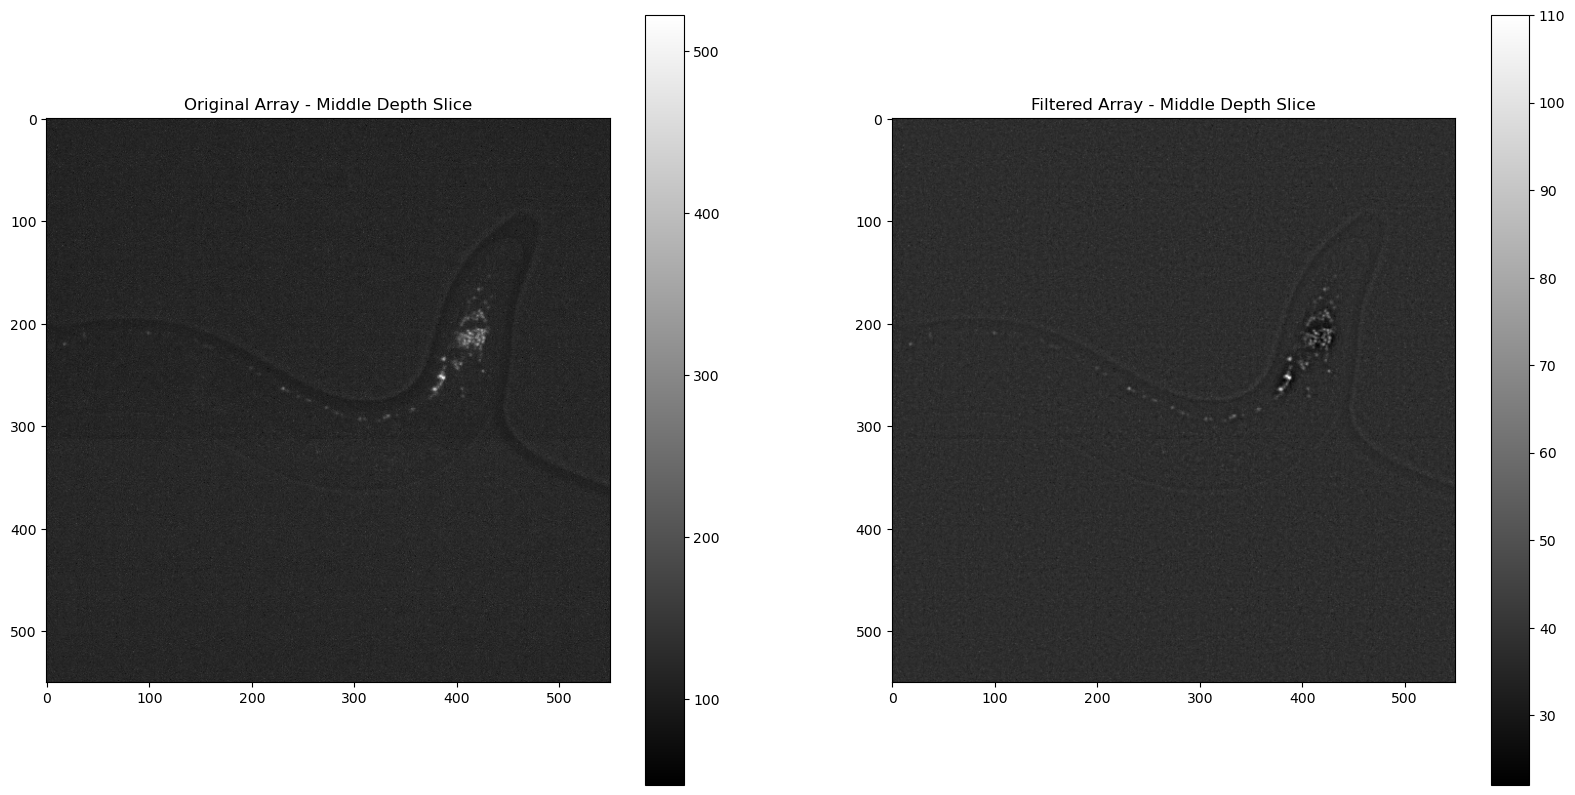

In [7]:
def dog_filter_2d(im, sigma1, sigma2):
    """Apply a difference of Gaussians filter"""
    im1 = gaussian_filter(im.astype(np.float32), sigma1)
    im2 = gaussian_filter(im.astype(np.float32), sigma2)
    return im1 - im2

# Ensure filtered_array is float32 or float64
filtered_array = np.zeros_like(aligned_array, dtype=np.float32)
total_iterations = T * C * D
sig1, sig2=0.5, 4

with tqdm(total=total_iterations, desc="Applying DoG filter") as pbar:
    for t in range(T):
        for c in range(C):
            for d in range(D):
                filtered_array[t, c, d] = dog_filter_2d(aligned_array[t, c, d], sig1, sig2)
                pbar.update(1)

# Normalize and scale the filtered array
filtered_array -= np.min(filtered_array)
filtered_array /= np.max(filtered_array)
filtered_array *= 255

# Convert to int8 after all floating-point operations are done
filtered_array = np.clip(filtered_array, 0, 255).astype(np.int8)
# Visualize the same frame from the filtered array
plt.figure(figsize=(20, 10))

# Plot original
plt.subplot(1, 2, 1)
plt.imshow(aligned_array[0, 0, D//2], cmap='gray')
plt.title('Original Array - Middle Depth Slice')
plt.colorbar()

# Plot filtered
plt.subplot(1, 2, 2) 
plt.imshow(filtered_array[0, 0, D//2], cmap='gray')
plt.title('Filtered Array - Middle Depth Slice')
plt.colorbar()

plt.show()



# Saving

In [8]:
# Define output path and file name
output_path = "./data/h5"
filename = '20241120_adult_1070'

# Ensure the output directory exists
os.makedirs(output_path, exist_ok=True)


N_neurons = 20 #so targettrack doesn't complain
# Save to HDF5 file
with h5py.File(os.path.join(output_path, filename+".h5"), 'w') as h5:
    # Save each time point
    for i in range(T):
        print(f"Saving time point {i}")
        dset = h5.create_dataset(f"{i}/frame", (C, W, H, D), dtype="i2", compression="gzip")
        dset[...] = np.transpose(filtered_array[i], (0, 2, 3, 1))  # Reorder dimensions to (C, W, H, D)
    
    # Set metadata attributes

    h5.attrs["name"] = filename
    h5.attrs["C"] = C
    h5.attrs["W"] = W
    h5.attrs["H"] = H
    h5.attrs["D"] = D
    h5.attrs["T"] = T
    h5.attrs["N_neurons"] = N_neurons

print("Finished saving the filtered array to HDF5 file.")


Saving time point 0
Saving time point 1
Saving time point 2
Saving time point 3
Saving time point 4
Saving time point 5
Saving time point 6
Saving time point 7
Saving time point 8
Saving time point 9
Saving time point 10
Saving time point 11
Saving time point 12
Saving time point 13
Saving time point 14
Saving time point 15
Saving time point 16
Saving time point 17
Saving time point 18
Saving time point 19
Saving time point 20
Saving time point 21
Saving time point 22
Saving time point 23
Saving time point 24
Saving time point 25
Saving time point 26
Saving time point 27
Saving time point 28
Saving time point 29
Saving time point 30
Saving time point 31
Saving time point 32
Saving time point 33
Saving time point 34
Saving time point 35
Saving time point 36
Saving time point 37
Saving time point 38
Saving time point 39
Saving time point 40
Saving time point 41
Saving time point 42
Saving time point 43
Saving time point 44
Saving time point 45
Saving time point 46
Saving time point 47
Sa